# Identifying PII in Student Essays
## Authored by: Pratik Chaudhari, Cody Ledford, Manu Achar
## Project Summary
The Kaggle Competition we are participating in is the [PII Data Detection hosted by The Learning Agency Lab](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/overview). The goal of this competition is to develop a model that detects sensitive personally identifiable information (PII) in student writing. This is necessary to screen and clean educational data so that when released to the public for analysis and archival, the students' risk are mitigated.


## Python Libraries


In [1]:
# !python -m pip install --upgrade pip

import pandas as pd
import numpy as np
# import spacy as sp
import re
# import json
import math
# from pathlib import Path
from datasets import Dataset
# import os
import torch
import torch.nn as nn
from torch import cuda

import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.font_manager import FontProperties

# !pip install evaluate
# !pip install seqeval
# import evaluate

# from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification

import warnings
warnings.filterwarnings('ignore')

2024-04-23 23:57:46.677645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 23:57:46.677755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 23:57:46.813726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Config

In [2]:
class Config():
    def __init__(self, platform, model_name, pretrained_model_name):
        # platform = 'Kaggle'# 
        if platform == 'kaggle':
            pretrained_model_loc = '/kaggle/input/huggingface-bert/' + pretrained_model_name
            data_path = "/kaggle/input/pii-detection-removal-from-educational-data/train.json"
            test_data_path = "/kaggle/input/pii-detection-removal-from-educational-data/test.json"
            model_path = '/kaggle/input/kag-notebook-pii-training/models/model-1-bert-base-cased/'
#             submission_path = '/kaggle/working/submission.csv'

        elif platform == 'local':
            pretrained_model_loc = pretrained_model_name
            model_path = '../models/bert_models/' + model_name + '/'
            data_path = "../Datasets/Official/train.json"
            submission_path = '../models/submission/'+ model_name + '-submission.csv'
            test_data_path = "../Datasets/Official/test.json"

        self.config = {
            'MAX_LEN': 100,
#             'TRAIN_BATCH_SIZE': 4,
#             'VALID_BATCH_SIZE': 2,
            'EPOCHS': 5,
            'LEARNING_RATE':1e-5,
#             'MAX_GRAD_NORM': 10,
            'device': 'cuda' if cuda.is_available() else 'cpu',
            'data_path': data_path,
            'test_data_path': test_data_path,
            'model_path': BertForTokenClassification.from_pretrained(model_path),
            'pretrained_model': BertForTokenClassification.from_pretrained(pretrained_model_loc, num_labels = 13),
            'tokenizer': BertTokenizerFast.from_pretrained(pretrained_model_loc),
#             'threshold': 0.9,
            'return_entity_level_metrics': True,
            'ignore_subwords': True, # DO NOT CHANGE
#             'subm_path': submission_path
        }

In [3]:
platform = 'local'
pretrainend_model_name = 'bert-base-cased'
model_num = 1
model_name = 'model-' + str(model_num) + '-' + pretrainend_model_name

config = Config(platform,model_name, pretrainend_model_name).config

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading Dataset


In [4]:
df_train = pd.read_json(config['data_path'])
df = df_train
df_test = pd.read_json(config['test_data_path'])

## Exploration

### Length of Essays

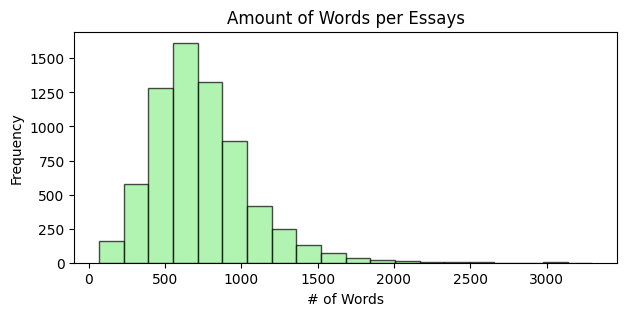

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))

plt.title('Amount of Words per Essays')
ax.hist(df['tokens'].apply(len), bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
ax.set_ylabel('Frequency')
ax.set_xlabel('# of Words')

plt.show()

### Proportion of PII as a percentage of number of words

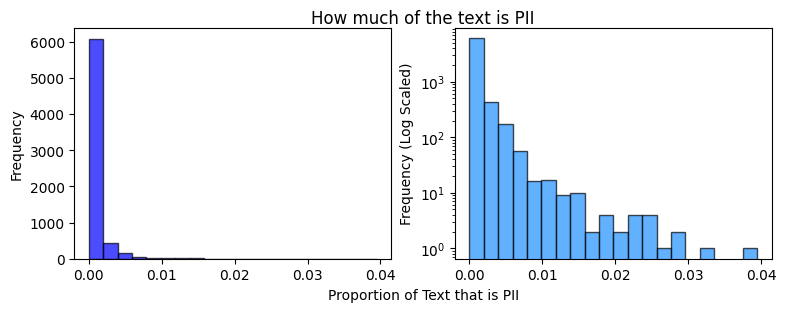

In [6]:
labels = df['labels']

non_o_values = df.apply(lambda line: sum(1 for x in line['labels'] if x != 'O') / len(line['labels']), axis = 1)
proportions_array = np.array(non_o_values)

fig, axs = plt.subplots(1,2, figsize=(9, 3))

axs[0].hist(proportions_array, bins=20, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Proportion of Text that is PII', x=1.1,y=-1)
axs[0].set_ylabel('Frequency')

axs[1].hist(proportions_array, bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
# axs[0].xlabel('Proportion of Text that is PII')
axs[1].set_yscale('log')
axs[1].set_ylabel('Frequency (Log Scaled)')

axs[0].set_title('How much of the text is PII', x=1.1,y=1.05,pad=-5)
plt.show()

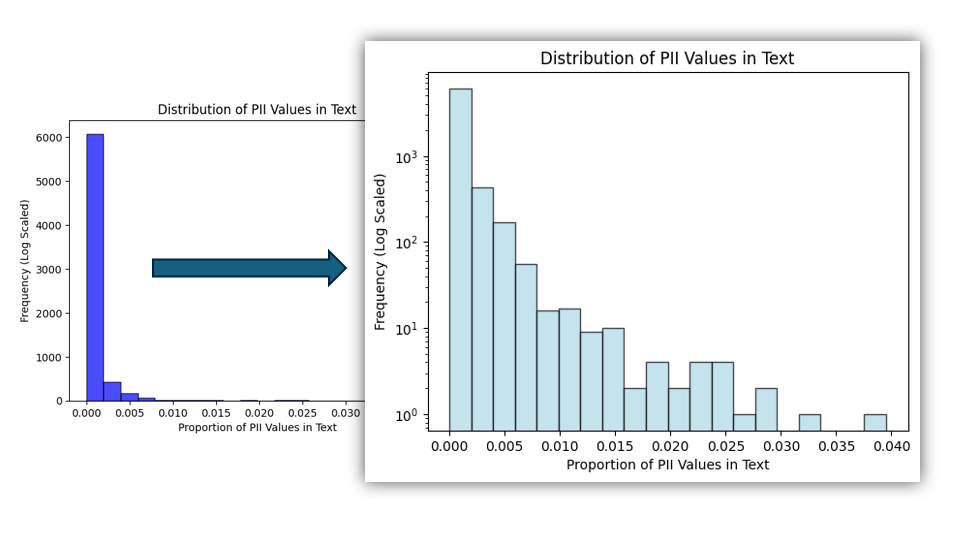

#### Hypothesis 1
Our claim is that there is at least 1 PII in each essay. We will use a t-test to evaluate this claim.

$H_0: μ_{PII}  = 0$

$H_a: μ_{PII}  > 0$

In [7]:
non_o_values1 = df.apply(lambda line: sum(1 for x in line['labels'] if x != 'O'), axis = 1)

t_statistic1, p_value1 = stats.ttest_1samp(non_o_values1, 0, alternative = 'greater')

print("t-statistic:", t_statistic1)
print("p-value:", p_value1)

t-statistic: 23.503261414082406
p-value: 8.178457800448455e-118


**Conclusion:**

Since the p-value < 0.0001 we reject $H_0$ and support the claim that there is at least 1 PII in each essay.

### Proprtion of each type of PII

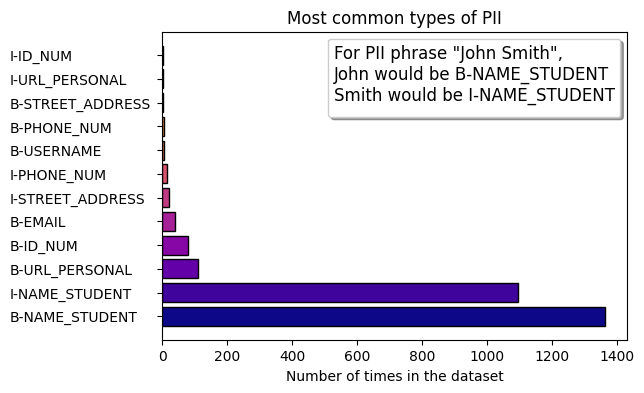

In [8]:
color_map = colormaps['plasma'].resampled(12)
color_map.colors

c = Counter()
df.apply(lambda line: c.update(line.labels), axis = 1)
c_pii = c.most_common()[1:]
c_key, c_val = zip(*c_pii)

fig, ax = plt.subplots(figsize=(6,4))
plt.barh(c_key, c_val, color=color_map.colors, edgecolor='black')

ax.set_yticklabels(c_key,ha = 'left')
plt.xlabel('Number of times in the dataset')
plt.title('Most common types of PII')
yax = ax.get_yaxis()
pad = max(T.label1.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad-35)
plt.legend(title='For PII phrase "John Smith",\nJohn would be B-NAME_STUDENT\nSmith would be I-NAME_STUDENT', title_fontsize='large', shadow=True, loc='upper right')
plt.show()

#### Hypothesis 2
Our claim is that names have a different likelihood to appear over the other PII.
To evaluate this claim, we will use a Tukey test.

$H_0: μ_{Names} = μ_{URL} = μ_{ID} = μ_{Email} = μ_{Address} = μ_{Phone} = μ_{Username}$

$H_a:  μ_{Names} \not=$ the others

In [9]:
def line_pii_cumulative(line):
  """Accumulate all of the pii in each line
  """
  c_line = Counter()
  c_line.update(line)
  c__line_pii = c_line.most_common()[1:]

  c_line_pii_cumulative = {'NAME': 0, 'URL': 0, 'ID': 0, 'EMAIL': 0, 'ADDRESS': 0, 'PHONE': 0, 'USERNAME': 0}

  for k,v in c__line_pii:
    if 'NAME_' in k:
      c_line_pii_cumulative['NAME'] += v
    elif 'URL' in k:
      c_line_pii_cumulative['URL'] += v
    elif 'ID' in k:
      c_line_pii_cumulative['ID'] += v
    elif 'EMAIL' in k:
      c_line_pii_cumulative['EMAIL'] += v
    elif 'ADDRESS' in k:
      c_line_pii_cumulative['ADDRESS'] += v
    elif 'PHONE' in k:
      c_line_pii_cumulative['PHONE'] += v
    elif 'USERNAME' in k:
      c_line_pii_cumulative['USERNAME'] += v
  return c_line_pii_cumulative


In [10]:
high_level_pii = ['NAME', 'URL', 'ID', 'EMAIL', 'ADDRESS', 'PHONE', 'USERNAME']

df1 = pd.DataFrame(data = df['labels'].apply(lambda line: line_pii_cumulative(line)).values)
df1 = pd.concat([df1.drop([0], axis = 1), df1[0].apply(pd.Series)], axis=1)

In [11]:
pvalues = stats.tukey_hsd(df1['NAME'], df1['URL'], df1['ID'], df1['EMAIL'], df1['ADDRESS'], df1['PHONE'], df1['PHONE']).pvalue

pd.options.display.float_format = '{:20,.5f}'.format
tukey_res = pd.DataFrame(pvalues < 0.0001, columns = high_level_pii, index = high_level_pii)
tukey_res[tukey_res].fillna('')

,NAME,URL,ID,EMAIL,ADDRESS,PHONE,USERNAME
NAME,,True,True,True,True,True,True
URL,True,,,,,,
ID,True,,,,,,
EMAIL,True,,,,,,
ADDRESS,True,,,,,,
PHONE,True,,,,,,
USERNAME,True,,,,,,


**Conclusion:**

Where there is a True in the table above, the relationship between that column and row is that they are likely to have different average numbers of PII.

This means we can reject $H_0$ and support the claim that Name PII has a different likelihood of appearing.

Furthermore, because we have shown it is different, and we have visualized that the # of Name PII is larger than the others, we can conclude that Name PII is more likely to appear with an alpha of 0.0001.

### Positional distribution of most popular PII

In [12]:
def count_pii_in_sections(line):
  positions = {
      'Section 1': lambda x: x[:len(x)//5],
      'Section 2': lambda x: x[len(x)//5:2*(len(x)//5)],
      'Section 3': lambda x: x[2*(len(x)//5):3*(len(x)//5)],
      'Section 4': lambda x: x[3*(len(x)//5):-(len(x)//5)],
      'Section 5': lambda x: x[-(len(x)//5):-1],
  }
  label_counts_PII = {pos: 0 for pos in positions}

  for pos, func in positions.items():
        temp_arr = func(line)
        for label in temp_arr:
                if label != 'O':
                     label_counts_PII[pos] += 1
  return label_counts_PII

In [13]:
locations = ['Section 1', 'Section 2', 'Section 3', 'Section 4', 'Section 5']

df2 = pd.DataFrame(data = df['labels'].apply(lambda line: count_pii_in_sections(line)).values)
df2 = pd.concat([df2.drop([0], axis = 1), df2[0].apply(pd.Series)], axis=1)
df3 = df2.apply(sum)

Text(0.5, 0, 'Divisions of Text')

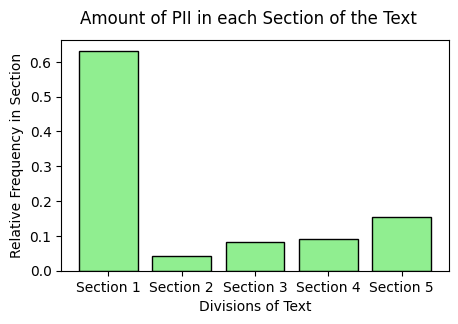

In [14]:
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df3.index, df3/sum(df3), color='lightgreen', edgecolor='black')
plt.suptitle('Amount of PII in each Section of the Text')
# plt.yticks(ax.get_yticks()))
plt.ylabel('Relative Frequency in Section')
plt.xlabel('Divisions of Text')

#### Hypothesis 3

Our claim is that PII has a different likelihood to appear in section 1 over the other sections.
To evaluate this claim, we will use a Tukey test.

$H_0: μ_1 = μ_2 = μ_3 = μ_4 = μ_5$

$H_a: μ_1 \not=$ the others

In [15]:
pvalues = stats.tukey_hsd(df2['Section 1'],df2['Section 2'],df2['Section 3'],df2['Section 4'],df2['Section 5']).pvalue

pd.options.display.float_format = '{:20,.5f}'.format
tukey_res = pd.DataFrame(pvalues < 0.0001, columns = locations, index = locations)
tukey_res[tukey_res].fillna('')

,Section 1,Section 2,Section 3,Section 4,Section 5
Section 1,,True,True,True,True
Section 2,True,,,,True
Section 3,True,,,,
Section 4,True,,,,
Section 5,True,True,,,


**Conclusion:**

Where there is a True in the table above, the relationship between that column and row is that they are likely to have different average numbers of PII.

This means that the PII found in sections 2,3,4 and 5. As well as that section 2 has a different average number of PII than the number of PII found in section 5.

This means we can reject  H0  and support the claim that PII is has a different likelihood of appearing in section 1.

Furthermore, because we have shown it is different, and we have visualized that the # of PII in section one is larger than the others, we can conclude that PII is more likely to appear in section 1 with an alpha of 0.0001

## Preprocessing

First we scoured the data to find the usuable text with our pretrained model with Regex.

In [16]:
labels = ["O","B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL"]

labels_to_ids = {k: v for v, k in enumerate(labels)}
ids_to_labels = {v: k for v, k in enumerate(labels)}

In [17]:
# pattern_space = re.compile('\xa0|\uf0b7|\u200b')
# df_train.loc[:,'full_text'] = df_train.loc[:,'full_text'].replace(pattern_space, ' ')
# df_train.loc[:,'tokens'] = df_train.loc[:,'tokens'].apply(lambda line: [tok for tok in line if not re.search(pattern_space,tok)])
# # [,.!?-]
# df_usable_train = df_train.iloc[df_train[~(df_train.tokens.apply(len) != df_train.labels.apply(len))].index]
# 1-(len(df_usable_train.document))/len(df.document)

In [18]:
# # df_test.loc[:,'full_text'] = df_test.loc[:,'full_text'].replace(pattern_space, ' ')
# df_test.loc[:,'tokens'] = df_test.loc[:,'tokens'].apply(lambda line: [pattern_space.sub("",tok) for tok in line])
# # [,.!?-]
# # df_usable_test = df_test.iloc[df_test[~(df_test.tokens.apply(len) != df_test.labels.apply(len))].index]
# # 1-(len(df_usable_test.document))/len(df.document)


In [19]:
def make_smaller_inputs(dataframe, type):
    """Splits the entire essays into MAX_LEN size blocks and remaps tokens and labels
    """
    df_out = pd.DataFrame(columns = ['tokens','labels','document','document_location'])
    idx_df = 0
    max_len = config['MAX_LEN']
    
    for _,line in dataframe.iterrows():
        location_counter = 0
        tokens = line.tokens
        if type == 'train':
            labels = line.labels
        document = line.document
        items = range(0,len(tokens),max_len)
        
        for i in items:
            df_out.at[idx_df,'tokens'] = tokens[i:i+max_len]
            if type == 'train':
                df_out.at[idx_df,'labels'] = labels[i:i+max_len]
            df_out.at[idx_df,'document'] = document
            df_out.at[idx_df,'document_location'] = location_counter
            location_counter += 1
            idx_df += 1
        
    return df_out

In [20]:
# df_model_input_train = make_smaller_inputs(df_usable_train,'train')
# print(len(df_model_input_train.index))
# df_model_input_train.head(2)

In [21]:
def replace_weird(line):
    out_tokens = []
    for tok in line:
        if len(tok) > 64:
            out_tokens.append('')
        else:
            out_tokens.append(tok)
    return out_tokens

In [22]:
# [print(tok) for tok in line if len(tok) > 64]
df_test.loc[:,'tokens'] = df_test.loc[:,'tokens'].apply(lambda line: replace_weird(line))

In [23]:
df_model_input_test = make_smaller_inputs(df_test,'predict')
print(len(df_model_input_test.index))
df_model_input_test.head(2)

90


,tokens,labels,document,document_location
0,"[Design, Thinking, for, innovation, reflexion,...",NaN,7,0
1,"['s, , potential, to, be, released, ., Cf, An...",NaN,7,1


In [24]:
# def compare2dict(list1, list2, pii_threshold):
#     return len(set(list1).intersection(set(list2))) > 1

In [25]:
# df_trainable = df_model_input_train[df_model_input_train.apply(lambda line: compare2dict(line.labels,list(labels_to_ids.keys()),0), axis = 1)]
# df_trainable_input = pd.concat([df_trainable] * 10).sample(frac=1)
# df_trainable_input.reset_index(drop = True, inplace=True)
# df_trainable_input = df_trainable_input[['tokens','labels']]
# print(len(df_trainable_input))
# df_trainable_input.head(2)

In [26]:
# df_evaluation_input = df_model_input[['tokens','labels']]
# df_evaluation_input.head(2)

In [27]:
df_prediction_input = df_model_input_test[['tokens','document','document_location']]
df_prediction_input.head(2)

,tokens,document,document_location
0,"[Design, Thinking, for, innovation, reflexion,...",7,0
1,"['s, , potential, to, be, released, ., Cf, An...",7,1


In [28]:
# df_prediction_input.iloc[2999].tokens

## PII Inference V2

### Prepping Trainer

Function for tokenizing datasets

In [29]:
def tokenize(line, tokenizer, type):

    tokens = line.tokens
    

    if config['ignore_subwords']:
        length = config['MAX_LEN']
    else:
        length = math.ceil(config['MAX_LEN'] * 1.2)
        

    encoding = tokenizer(tokens,
                         is_split_into_words= True,
                         return_offsets_mapping= True,
                         padding= 'max_length',
                         max_length= length)
    
    item = {key: torch.as_tensor(val) for key, val in encoding.items()}
    
    if type == 'train' or type == 'eval':
        word_labels = line.labels
    
        temp_list = [0 for _ in range(length - len(word_labels))]
        labels = [labels_to_ids[label] for label in word_labels] + temp_list
        
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        i = 0
    
        if config['ignore_subwords']:
            #         Ignore subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0 and mapping[1] != 0:
                    # overwrite label
                    encoded_labels[idx] = labels[i]
                    i += 1
        else:
            #         Extend subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0:
                    encoded_labels[idx] = labels[i]
                    i += 1
                    
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return {**item}
        
    if type == 'predict':
        document = line.document
        location = line.document_location
        
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        labels = np.zeros(len(tokens), dtype=int)
        i = 0
    
        if config['ignore_subwords']:
            #         Ignore subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0 and mapping[1] != 0:
                    # overwrite label
                    encoded_labels[idx] = labels[i]
                    i += 1
        else:
            #         Extend subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0:
                    encoded_labels[idx] = labels[i]
                    i += 1
        item['labels'] = torch.as_tensor(encoded_labels)
        if len(item['input_ids']) > 512:
            print(f"{document} {location}")
        return {**item, 'document': document, 'location': location}

Create Datasets

In [30]:
# train_dataset_temp = df_trainable_input.apply(lambda line: tokenize(line, config['tokenizer'],'train'), axis = 1).to_list()
# # train_dataset_temp
# # train_dataset = Dataset.from_list(pd.DataFrame(data=train_dataset_temp))

# # from_list not implemented in this notebook's version of datasets, janky version of the above
# train_dataset = Dataset.from_dict({k: [s[k] for s in train_dataset_temp] for k in  train_dataset_temp[0].keys()})
# train_dataset

In [31]:
# eval_dataset_temp = df_evaluation_input.apply(lambda line: tokenize(line, config['tokenizer'],'eval'), axis = 1)
# # # eval_dataset = Dataset.from_list(eval_dataset_temp)
# eval_dataset = Dataset.from_dict({k: [s[k] for s in eval_dataset_temp] for k in  eval_dataset_temp[0].keys()})
# eval_dataset

In [32]:
predict_dataset_temp = df_prediction_input.apply(lambda line: tokenize(line, config['tokenizer'],'predict'), axis = 1)
# predict_dataset = Dataset.from_list(predict_dataset_temp)
predict_dataset = Dataset.from_dict({k: [s[k] for s in predict_dataset_temp] for k in  predict_dataset_temp[0].keys()})
predict_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'document', 'location'],
    num_rows: 90
})

Initialize parts of trainer

In [33]:
# temp = set()
# for i in range(53279):
#     temp.add(len(predict_dataset[i]['input_ids']))
# temp

In [34]:
model = config['model_path']
data_collator = DataCollatorForTokenClassification(config['tokenizer'])
# metric = evaluate.load("seqeval")

Function for evaluating prediction. Only available online

In [35]:
# def compute_metrics(p):
#     predictions, labels = p
#     predictions = np.argmax(predictions, axis=2)

#     # Remove ignored index (special tokens)
#     true_predictions = [
#         [ids_to_labels[p] for (p, l) in zip(prediction, label) if l != -100]
#         for prediction, label in zip(predictions, labels)
#     ]
#     true_labels = [
#         [ids_to_labels[l] for (p, l) in zip(prediction, label) if l != -100]
#         for prediction, label in zip(predictions, labels)
#     ]

#     results = metric.compute(predictions=true_predictions, references=true_labels)
#     if config['return_entity_level_metrics']:
#         # Unpack nested dictionaries
#         final_results = {}
#         for key, value in results.items():
#             if isinstance(value, dict):
#                 for n, v in value.items():
#                     final_results[f"{key}_{n}"] = v
#             else:
#                 final_results[key] = value
#         return final_results
#     else:
#         return {
#             "precision": results["overall_precision"],
#             "recall": results["overall_recall"],
#             "f1": results["overall_f1"],
#             "accuracy": results["overall_accuracy"],
#         }

### Training

Initialize Trainer

In [36]:
training_args = TrainingArguments(
    output_dir= '.',
#     overwrite_output_dir = True,
    do_train = False,
    do_predict = True,
#     do_eval = False,
    per_device_eval_batch_size = 1,
#     auto_find_batch_size=True,
    eval_accumulation_steps = 10,
    report_to="none",
#     num_train_epochs = config['EPOCHS'],
#     learning_rate = config['LEARNING_RATE'],
#     save_strategy = 'no',
    disable_tqdm= False,
    no_cuda = False,
)

trainer = Trainer(
    model=model,
    args=training_args,
#     train_dataset = train_dataset,
#     eval_dataset = eval_dataset,
    # predict_dataset = predict_dataset,
    data_collator=data_collator,
#     compute_metrics=compute_metrics,
)

Start training

In [37]:
# Training
if training_args.do_train:
    train_result = trainer.train()
#     metrics = train_result.metrics
    trainer.save_model()  # Saves the tokenizer too for easy upload

#     metrics["train_samples"] = len(train_dataset)

#     trainer.log_metrics("train", metrics)
#     trainer.save_metrics("train", metrics)
    # trainer.save_state()

Reassign model from kaggle output

In [38]:
# trainer.model = BertForTokenClassification.from_pretrained(config['model_path'])
# trainer.model.to(config['device'])

### Evaluation

In [39]:
# # Evaluation
# if training_args.do_eval:
# #     logger.info("*** Evaluate ***")

#     metrics = trainer.evaluate()

#  #   max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)
#     metrics["eval_samples"] = len(eval_dataset)

#     trainer.log_metrics("eval", metrics)
#     trainer.save_metrics("eval", metrics)

### Prediction

In [40]:
# Predict
if training_args.do_predict:
    # logger.info("*** Predict ***")

    predictions, labels, metrics = trainer.predict(predict_dataset, metric_key_prefix="predict")
    predictions = predictions.argmax(-1)

    # Remove ignored index (special tokens)
    true_predictions = [
        [ids_to_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

#     trainer.log_metrics("predict", metrics)
#     trainer.save_metrics("predict", metrics)

### Build Submission

In [41]:
results = []
for preds, location, doc in zip(
    true_predictions, 
    predict_dataset["location"], 
    predict_dataset["document"]
):
    results.extend([(doc, location * config['MAX_LEN'] + idx, label) for idx, label in enumerate(preds) if label != 'O'])

In [42]:
df_submission = pd.DataFrame(results, columns = ['document','token','label'])
df_submission['row_id'] = df_submission.index
df_submission_final = df_submission[['row_id','document','token','label']]
df_submission_final

,row_id,document,token,label
0,0,7,9,B-NAME_STUDENT
1,1,7,10,I-NAME_STUDENT
2,2,7,108,B-ID_NUM
3,3,7,482,B-NAME_STUDENT
4,4,7,483,I-NAME_STUDENT
5,5,7,741,B-NAME_STUDENT
6,6,7,742,I-NAME_STUDENT
7,7,10,0,B-NAME_STUDENT
8,8,10,1,I-NAME_STUDENT
9,9,10,464,B-NAME_STUDENT


In [43]:
# df_submission_final.to_csv(config['subm_path'],index = False)

In [44]:
df_submission_final.to_csv('submission.csv',index = False)